In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import pandas_profiling
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import warnings

warnings.filterwarnings("ignore")
# plt.style.use('fast')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

In [2]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

In [3]:
data_m = data['PJME_MW'].resample('M').mean()

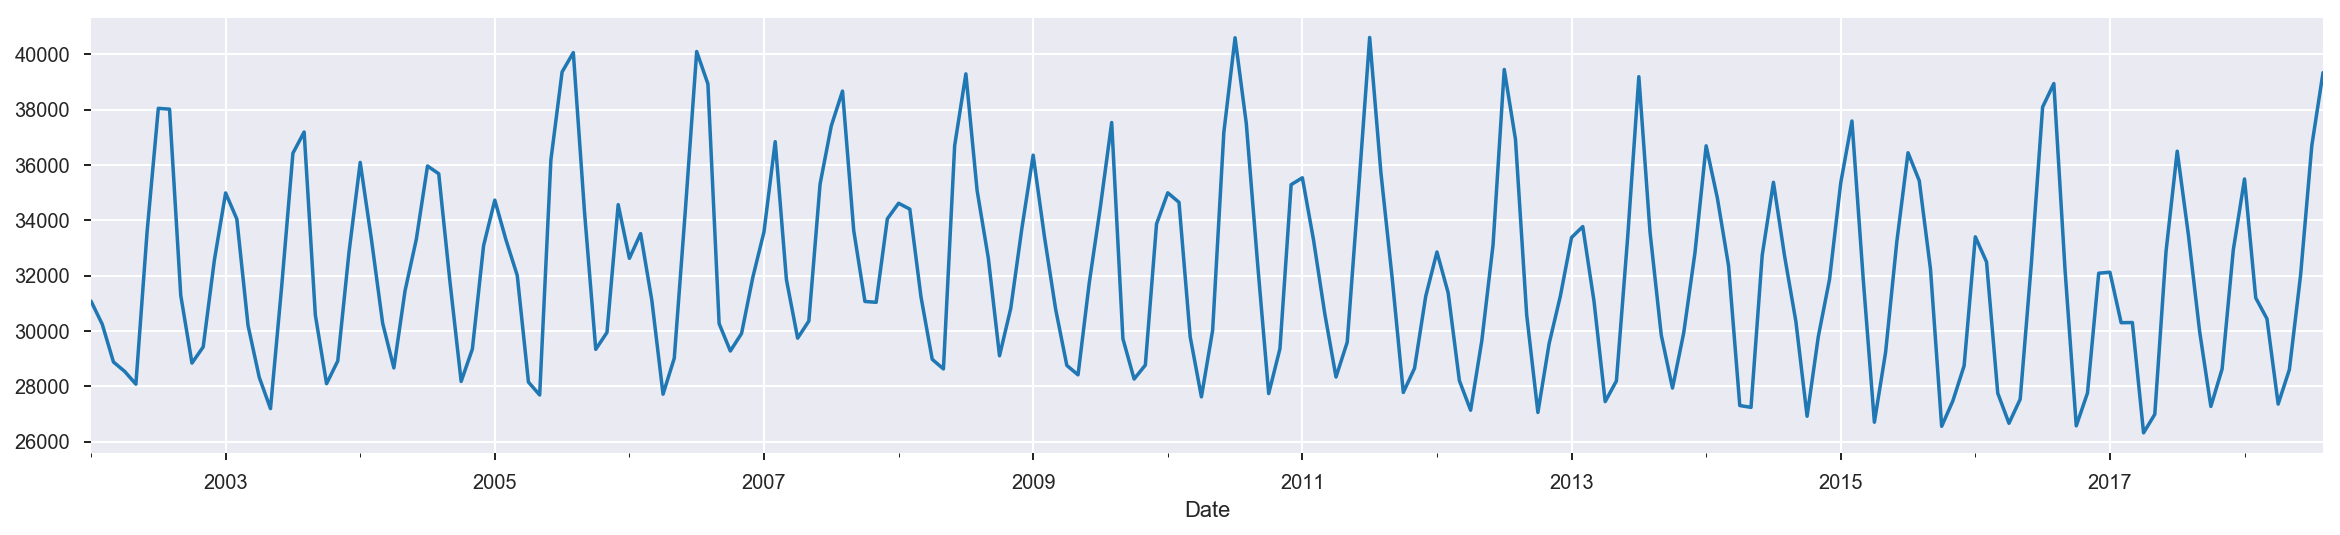

In [4]:
plt.figure(figsize =(20,4))
data_m.plot()

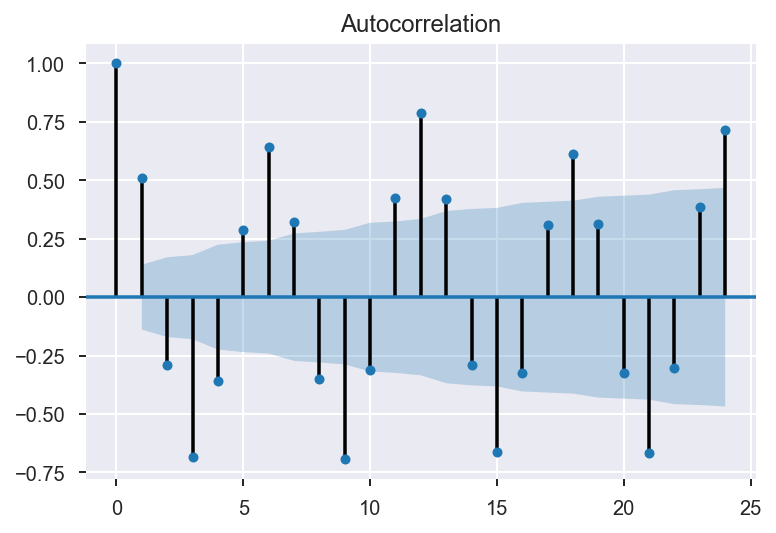

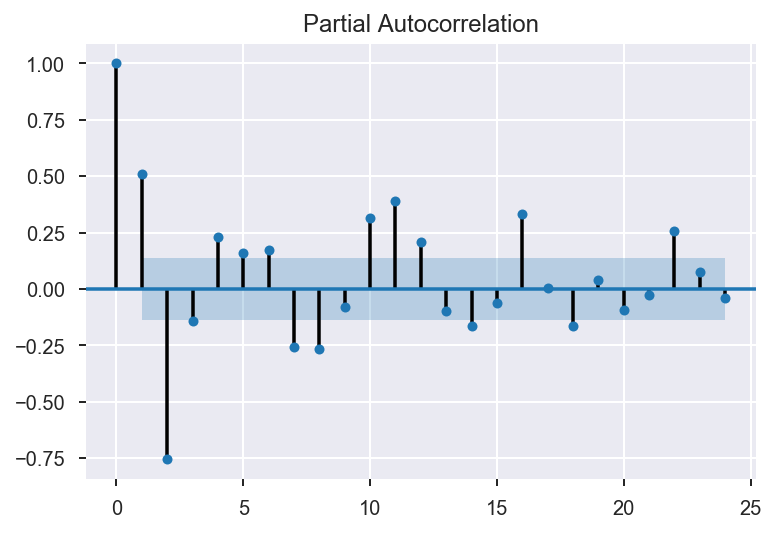

In [52]:
sm.graphics.tsa.plot_acf(data_m.values, lags=24)
plt.show()
sm.graphics.tsa.plot_pacf(data_m.values, lags=24)
plt.show()

Примем сезоность в 24 месяца

Тестовая выборку примем в размере последнего года

In [127]:
# Определим p, d и q 
p = 1
d = 2
q = 2
pdq = [p, d, q]
# определим комбинации сезонных параметров p, q и q, 
#будем работать с месячными данными, тогда сезонность это 12 месяцев

ps = 0
ds = 1
qs = 1
seasonal_pdq = [ps, ds, qs ,24] 

In [128]:
print('SARIMAX: p,d,q=',pdq,'   : ps,ds,qs, S=', seasonal_pdq)

SARIMAX: p,d,q= [1, 2, 2]    : ps,ds,qs, S= [0, 1, 1, 24]


In [129]:
mod = sm.tsa.statespace.SARIMAX(data_m.values[:-12],order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)

In [130]:
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))

SARIMAX[1, 2, 2]x[0, 1, 1, 24] - AIC:2442.392473001669


In [131]:
print(results.summary().tables[0],results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  188
Model:             SARIMAX(1, 2, 2)x(0, 1, 1, 24)   Log Likelihood               -1216.196
Date:                            Sun, 08 Dec 2019   AIC                           2442.392
Time:                                    16:23:47   BIC                           2456.919
Sample:                                         0   HQIC                          2448.296
                                            - 188                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

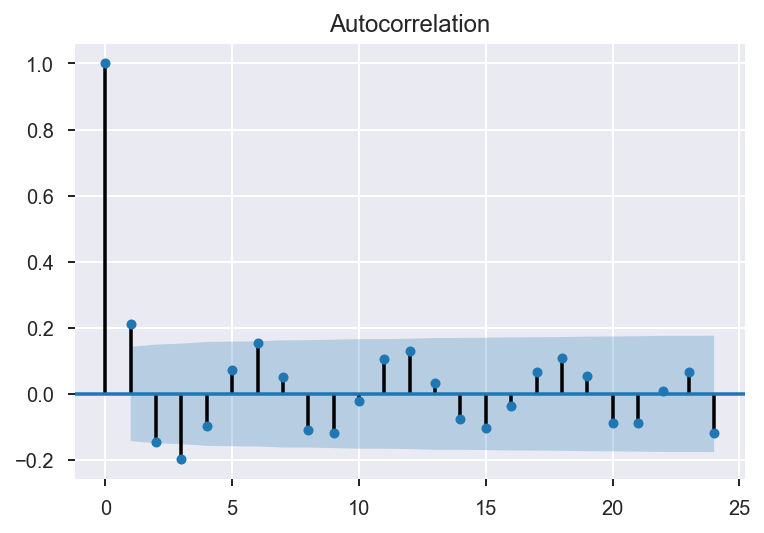

In [132]:
sm.graphics.tsa.plot_acf(results.resid, lags=24)
plt.show()

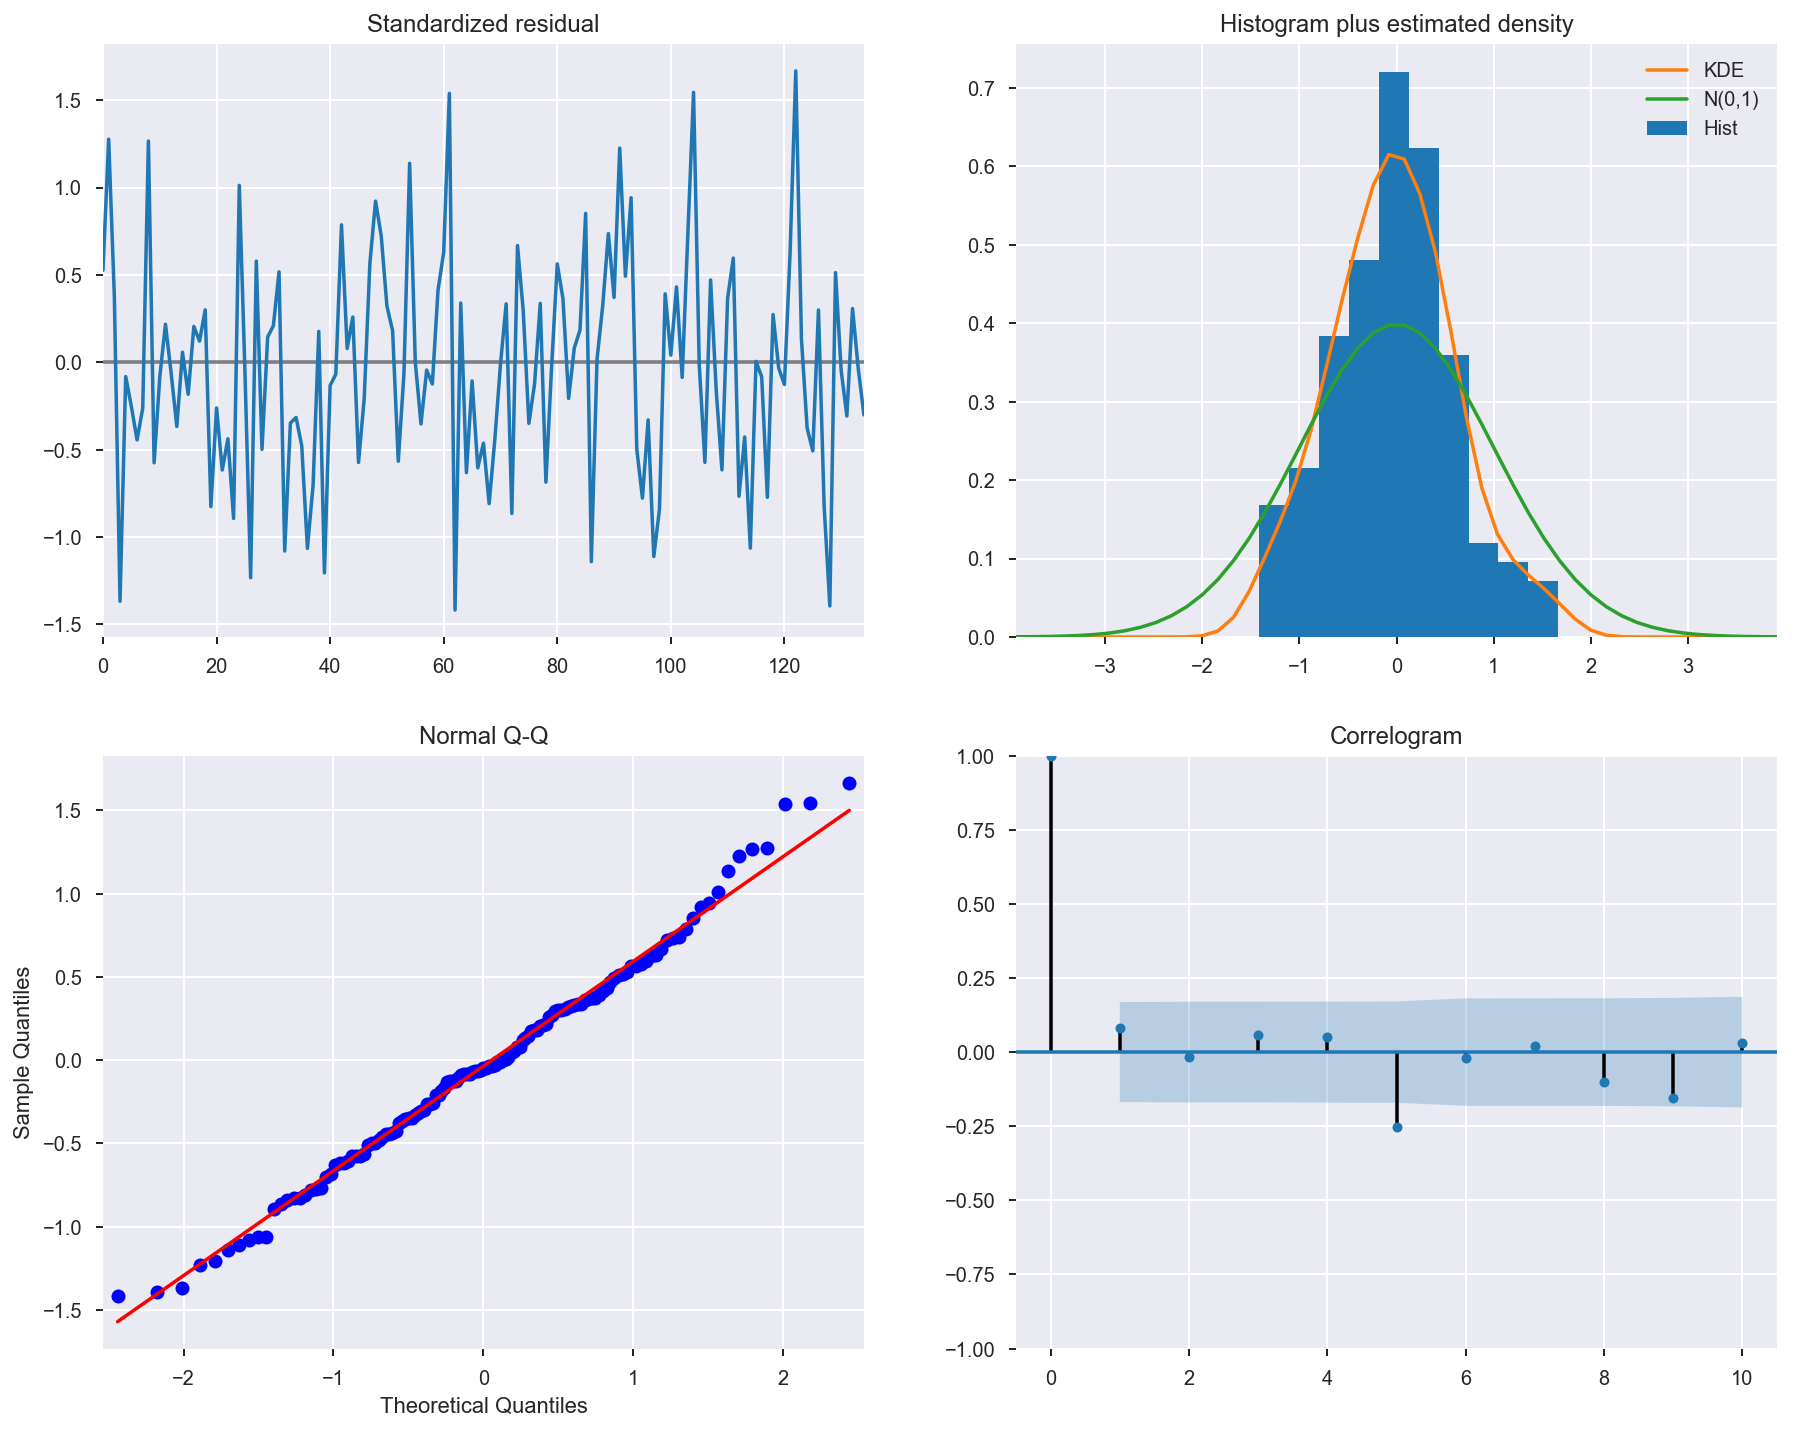

In [133]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()


Остатки вполне похожи на нормальное распределение

Переберем значение праметров модели по сетке

In [111]:
import itertools
# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

In [85]:
models = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = dict()
            mod = sm.tsa.statespace.SARIMAX(data_m.values[:-12],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            model['param'] = param, param_seasonal
            model['aic'] = results.aic
            # print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))
            models.append(model)
        except:
            continue
        

Лучшие параметры модели:

In [113]:
sorted(models, key=lambda x: x['aic'])[0]

{'param': ((0, 0, 0), (2, 2, 0, 24)), 'aic': 1692.658877864246}

In [122]:
# для построения модели используем все данные, кроме последнего года (это будет тестовый набор)
mod = sm.tsa.statespace.SARIMAX(data_m.values[:-12],order=[0,0,0],
                                seasonal_order=[2,2,0,24] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)

AIC:{} 1692.658877864246


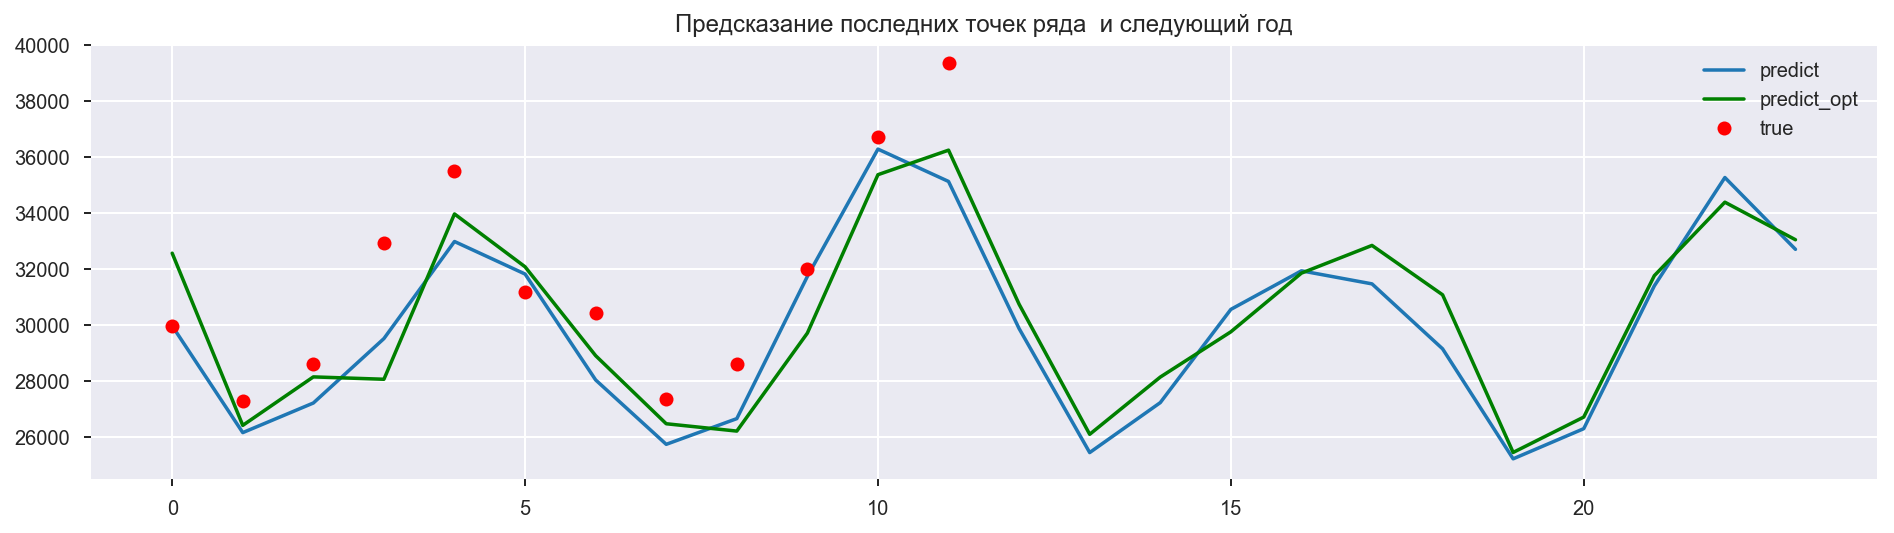

In [134]:
pred_dynamic = results.forecast(24)    #делаем предсказание еще на год вперед
pred_dynamic_opt = results_opt.forecast(24)

plt.figure(figsize =(16,4))
plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_m.values[-12:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующий год')
plt.legend()

plt.show()

Как я понимаю, в отличие от недельной, данная модель берет в расчет только сезонные составляющие ряда (без их интегральной составляющей). 